In [24]:
import numpy as np

import skxray.core.roi as roi
import skxray.core.utils as utils

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid

import xray_vision.mpl_plotting as mpl_plot
import matplotlib.patches as mp

# Easily switch between interactive and static matplotlib plots
interactive_mode = False

if interactive_mode:
    %matplotlib notebook
else:
    %matplotlib inline

backend = mpl.get_backend()

In [1]:
def test_demo(ax, inds, pix_list, img_dim):

    tt = np.zeros(img_dim).ravel() * np.nan
    tt[pix_list] = inds

    ax.cla()
    ax.set_aspect('equal')
    im = ax.imshow(tt.reshape(*img_dim), cmap='Paired', interpolation='nearest')
    Y, X = np.meshgrid(range(img_dim[0]), range(img_dim[1]))
    ax.plot(X.ravel(), Y.ravel(), 'x')


In [18]:
def test_demo_circle(ax, center, inds, edges, pix_list, img_dim):

    tt = np.zeros(img_dim).ravel() * np.nan
    tt[pix_list] = inds

    ax.cla()
    ax.set_aspect('equal')
    im = ax.imshow(tt.reshape(*img_dim), cmap='Paired', interpolation='nearest')

    [ax.add_artist(mp.Circle(center, radius=j, lw=3, facecolor='none',
                             edgecolor='k')) for j in edges[:, 0]]
    [ax.add_artist(mp.Circle(center, radius=j, lw=3, facecolor='none', edgecolor='k',
                             linestyle='dashed')) for j in edges[:, 1]]
    Y, X = np.meshgrid(range(img_dim[0]), range(img_dim[1]))
    ax.plot(X.ravel(), Y.ravel(), 'x')
    ax.set_title(str(center))
    

In [4]:
calibrated_center = (4., 6.)
img_dim = (20, 25)
first_q = 2.5
delta_q = 2

# using a step for the Q rings
num_qs = 6  # number of Q rings
step_q = 1  # step value between each Q ring

In [5]:
edges = roi.ring_edges(first_q, delta_q, step_q, num_rings=6)
edges

array([[  2.5,   4.5],
       [  5.5,   7.5],
       [  8.5,  10.5],
       [ 11.5,  13.5],
       [ 14.5,  16.5],
       [ 17.5,  19.5]])

In [7]:
rings = roi.rings(edges, calibrated_center, img_dim)

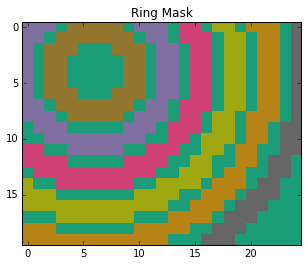

In [10]:
#plot the figure
fig, axes = plt.subplots()
axes.set_title("Ring Mask")
im = mpl_plot.show_label_array(axes, rings, cmap="Dark2")
plt.show()


In [11]:
labels, indices = roi.extract_label_indices(rings)

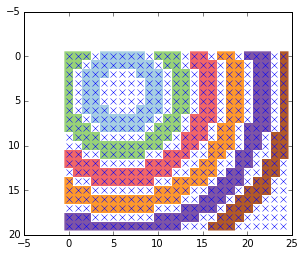

In [13]:
fig, axes = plt.subplots()
test_demo(axes, labels, indices, img_dim)
plt.show()

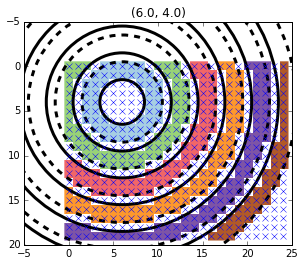

In [20]:
fig, ax = plt.subplots()
test_demo_circle(ax, (6., 4.), labels, edges, indices, img_dim)

In [28]:
def rings_c(edges, center, shape):
    """
    Draw annual (ring-shaped) regions of interest.
    Each ring will be labeled with an integer. Regions outside any ring will
    be filled with zeros.
    Parameters
    ----------
    edges: list
        giving the inner and outer radius of each ring
        e.g., [(1, 2), (11, 12), (21, 22)]
    center : tuple
        point in image where r=0; may be a float giving subpixel precision.
        Order is (rr, cc).
    shape: tuple
        Image shape which is used to determine the maximum extent of output
        pixel coordinates. Order is (rr, cc).
    Returns
    -------
    label_array : array
        Elements not inside any ROI are zero; elements inside each
        ROI are 1, 2, 3, corresponding to the order they are specified
        in edges.
    """
    edges = np.atleast_2d(np.asarray(edges)).ravel()
    if not 0 == len(edges) % 2:
        raise ValueError("edges should have an even number of elements, "
                         "giving inner, outer radii for each ring")
    if not np.all(np.diff(edges) >= 0):
        raise ValueError("edges are expected to be monotonically increasing, "
                         "giving inner and outer radii of each ring from "
                         "r=0 outward")
    r_coord = utils.radial_grid(center, shape).ravel()
    # ***********************************************************
    label_array = np.digitize(r_coord, edges, right=True)  # changed right to True
    # Even elements of label_array are in the space between rings.
    label_array = (np.where(label_array % 2 != 0, label_array, 0) + 1) // 2
    return label_array.reshape(shape)

In [29]:
rings_c = rings_c(edges, calibrated_center, img_dim)

In [30]:
labels_c, indices_c = roi.extract_label_indices(rings_c)

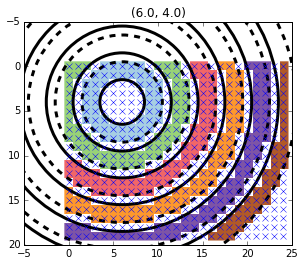

In [31]:
fig, ax = plt.subplots()
test_demo_circle(ax, (6., 4.), labels_c, edges, indices_c, img_dim)